# Setup

In [29]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import os

from datetime import datetime
from copy import deepcopy
from torch import nn
from torchvision import transforms
from tqdm import tqdm

from cifar10_utils import get_cifar10, get_dataloader
from models import Bottleneck, ResNet, CBAM, eca_layer

!pip install grad-cam --quiet
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=1a9d03239391c09a70e2ec457b5dba9aed28066d9662f43cc04a56c93b0ee8ce
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [2]:
# Seed for reproduceability
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [23]:
def save_model_and_data(name, model, test_accuracy, test_loss, logging_dict):
    os.mkdir(f'./models/{name}')
    torch.save(model, f'./models/{name}/{name}.pt')
    data = {'test_accuracy': test_accuracy,
            'test_loss': test_loss,
            'logging_dict': logging_dict,
            'datetime': datetime.now()}
    with open(f'./models/{name}/{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
def make_plots(logging_dict, model_name, avg_train=True):
#     logging_dict = {'loss': {'train': [], 'validation': []},
#                 'accuracy': {'train': [], 'validation': []},
#                 'lr': [],
#                 'batches_per_epoch': [],}
    epoch_ends = np.cumsum(logging_dict['batches_per_epoch'])
    
    def get_avg_per_epoch(batch_data):
        result = [None,]
        for i in range(len(epoch_ends) - 1):
            result.append(np.average(batch_data[epoch_ends[i]:epoch_ends[i + 1]]))
        return result
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    metrics = ('loss', 'accuracy')
    for metric, ax in zip(metrics, axes.ravel()):
#         ax.plot(logging_dict[metric]['train'])
        if avg_train:
            ax.plot(get_avg_per_epoch(logging_dict[metric]['train']), '.-', label='training set')
            ax.plot(logging_dict[metric]['validation'], '.-', label='validation set')
            ax.set(title=metric, xlabel='epoch', xticks=np.arange(len(epoch_ends)))
        else:
            ax.plot(logging_dict[metric]['train'],'.-', label='training set')
            ax.plot(epoch_ends, logging_dict[metric]['validation'],'.-', label='validation set')
            ax.set(title=metric, xlabel='batch')
    
    handles, labels = ax.get_legend_handles_labels()
    plt.figlegend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

## Backbone Architecture

We will use ResNet50 as our backbone architecture. The code is taken from [this GitHub repository by Maciej Balawejder](https://github.com/maciejbalawejder/Deep-Learning-Collection/tree/main/ConvNets/ResNet).

In [3]:
# Loading the dataset
cifar10 = get_cifar10()
cifar10_loader = get_dataloader(cifar10, batch_size=128,return_numpy=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def evaluate_model(model, data_loader):
    """
    Performs the evaluation of the MLP model on a given dataset.

    Args:
      model: An instance of 'MLP', the model to evaluate.
      data_loader: The data loader of the dataset to evaluate.
    Returns:
        accuracy
    """
    accuracies_per_batch, losses_per_batch = [], []
    loss_module = nn.CrossEntropyLoss()
    # Get accuracy for epoch
    for batch in data_loader:
        
        # Get validation images and labels
        X = batch[0].to(device)
        y = batch[1].to(device)
        
        # Get predictions on validation set
        model.eval()
        with torch.no_grad():
            pred_logits = model.forward(X)
            pred_classes = torch.argmax(torch.softmax(pred_logits, dim=1), axis=1)
        
        # Calculate accuracy := # of correct preds / total # of preds
        current_accuracy = torch.sum(pred_classes == y) / pred_classes.shape[0]
        accuracies_per_batch.append(current_accuracy.item())
        current_loss = loss_module(pred_logits, y).item()
        losses_per_batch.append(current_loss)

    accuracy = np.average(accuracies_per_batch)
    loss = np.average(losses_per_batch)

    return accuracy, loss

In [5]:
def train(model, epochs=15, lr=0.01, momentum=0.9, verbose=True):
    
    logging_dict = {'loss': {'train': [], 'validation': []},
                    'accuracy': {'train': [], 'validation': []},
                    'lr': [],
                    'batches_per_epoch': [],}
    
    for epoch in tqdm(range(epochs)):
        
        batches_per_epoch = 0
        
        model.train()
        
        # Loss module and optimizer
        loss_module = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        
         
        for batch in cifar10_loader['train']:
                        
            batches_per_epoch += 1
            
            # Get training images and labels
            X_train = batch[0].to(device)
            y_train = batch[1].to(device)
            
            # Forward pass
            train_pred_logits = model.forward(X_train)
            
            # Calculate loss
            loss = loss_module(train_pred_logits, y_train)
            logging_dict['loss']['train'].append(loss.item())
            
            # Calculate accuracy
            train_pred_class = torch.argmax(torch.softmax(train_pred_logits, dim=1), axis=1)
            train_accuracy = torch.sum(train_pred_class == y_train) / train_pred_class.shape[0]
            logging_dict['accuracy']['train'].append(train_accuracy.item())
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()

        
        # Log num of batches for this epoch
        logging_dict['batches_per_epoch'].append(batches_per_epoch)
        
        # Log current LR
        logging_dict['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Update LR
        scheduler.step(loss)
        
        # Get metrics on validation set
        validation_accuracy, validation_loss = evaluate_model(model, cifar10_loader['validation'])
        logging_dict['accuracy']['validation'].append(validation_accuracy.item())
        logging_dict['loss']['validation'].append(validation_loss.item())
        
        # Determine if best model
        if len(logging_dict['accuracy']['validation']) == 1 or \
            all([validation_accuracy > acc for acc in logging_dict['accuracy']['validation']]):
            best_model = deepcopy(model)
   
        if verbose:
            print(f'\n{epoch = }, '
                  f'training accuracy: {train_accuracy.item():.3f}, '
                  f'training loss: {loss.item():.3f}',
                  f'validation accuracy: {validation_accuracy.item():.3f}, '
                  f'validation loss: {validation_loss.item():.3f}',
                 )
    
    # Get metrics on test set
    test_accuracy, test_loss = evaluate_model(best_model, cifar10_loader['test'])
    
    return best_model, test_accuracy, test_loss, logging_dict

# Vanilla ResNet

In [6]:
# resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], 10).to(device)
# resnet_best_model, resnet_test_acc, resnet_test_loss, resnet_logging_dict = train(resnet50)

In [12]:
layers = [3, 4, 6, 3]
resnet50_eca = ResNet(Bottleneck,
                       layers,
                       10,
                       extra_modules_list=[[eca_layer(layer * 4 , 3).to(device)] for layer in layers],
                       before_downsampling_list=[[True] for layer in layers]).to(device)
eca_best_model, eca_test_acc, eca_test_loss, eca_logging_dict = train(resnet50_eca)

  7%|▋         | 1/15 [00:53<12:33, 53.80s/it]


epoch = 0, training accuracy: 0.414, training loss: 1.510 validation accuracy: 0.454, validation loss: 1.564


 13%|█▎        | 2/15 [01:47<11:35, 53.47s/it]


epoch = 1, training accuracy: 0.398, training loss: 1.531 validation accuracy: 0.530, validation loss: 1.315


 20%|██        | 3/15 [02:41<10:45, 53.83s/it]


epoch = 2, training accuracy: 0.562, training loss: 1.185 validation accuracy: 0.545, validation loss: 1.314


 27%|██▋       | 4/15 [03:36<09:57, 54.33s/it]


epoch = 3, training accuracy: 0.602, training loss: 1.097 validation accuracy: 0.571, validation loss: 1.198


 33%|███▎      | 5/15 [04:32<09:07, 54.79s/it]


epoch = 4, training accuracy: 0.648, training loss: 0.996 validation accuracy: 0.618, validation loss: 1.104


 40%|████      | 6/15 [05:27<08:15, 55.03s/it]


epoch = 5, training accuracy: 0.734, training loss: 0.651 validation accuracy: 0.609, validation loss: 1.170


 47%|████▋     | 7/15 [06:23<07:21, 55.19s/it]


epoch = 6, training accuracy: 0.797, training loss: 0.576 validation accuracy: 0.614, validation loss: 1.287


 53%|█████▎    | 8/15 [07:18<06:27, 55.29s/it]


epoch = 7, training accuracy: 0.859, training loss: 0.374 validation accuracy: 0.600, validation loss: 1.435


 60%|██████    | 9/15 [08:14<05:32, 55.37s/it]


epoch = 8, training accuracy: 0.836, training loss: 0.458 validation accuracy: 0.619, validation loss: 1.551


 67%|██████▋   | 10/15 [09:09<04:37, 55.44s/it]


epoch = 9, training accuracy: 0.906, training loss: 0.309 validation accuracy: 0.604, validation loss: 1.710


 73%|███████▎  | 11/15 [10:05<03:41, 55.47s/it]


epoch = 10, training accuracy: 0.922, training loss: 0.182 validation accuracy: 0.629, validation loss: 1.633


 80%|████████  | 12/15 [11:00<02:46, 55.48s/it]


epoch = 11, training accuracy: 0.945, training loss: 0.127 validation accuracy: 0.629, validation loss: 1.733


 87%|████████▋ | 13/15 [11:56<01:50, 55.48s/it]


epoch = 12, training accuracy: 0.953, training loss: 0.144 validation accuracy: 0.621, validation loss: 1.859


 93%|█████████▎| 14/15 [12:51<00:55, 55.54s/it]


epoch = 13, training accuracy: 0.961, training loss: 0.165 validation accuracy: 0.641, validation loss: 1.861


100%|██████████| 15/15 [13:47<00:00, 55.16s/it]


epoch = 14, training accuracy: 0.984, training loss: 0.079 validation accuracy: 0.634, validation loss: 1.887


In [10]:
layers = [3, 4, 6, 3]
resnet50_cbam = ResNet(Bottleneck,
                       layers,
                       10,
                       extra_modules_list=[[CBAM(layer * 4 , 16).to(device)] for layer in layers],
                       before_downsampling_list=[[False] for layer in layers]).to(device)
cbam_best_model, cbam_test_acc, cbam_test_loss, cbam_logging_dict = train(resnet50_cbam)

  0%|          | 0/15 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x256 and 12x0)

In [106]:
eca_best_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
save_model_and_data('eca', eca_best_model, eca_test_acc, eca_test_loss, eca_logging_dict)

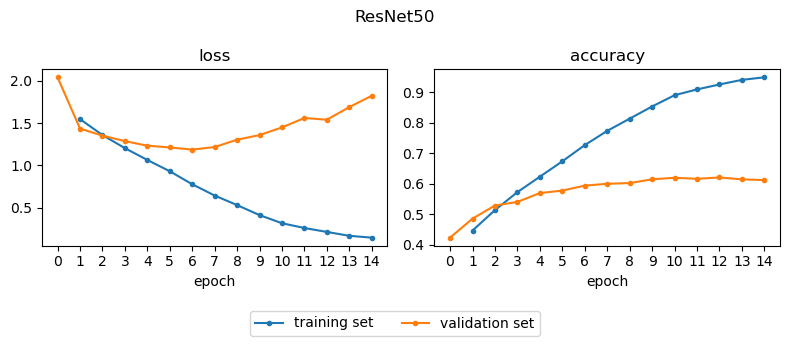

In [10]:
make_plots(resnet_logging_dict, 'ResNet50', avg_train=True)

## GradCAM

Docs: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

In [73]:
classes_names = {i: c for i, c in enumerate (('airplane', 'automobile', 'bird', 'cat', 'deer',
                                              'dog', 'frog', 'horse', 'ship', 'truck',))}

def show_activations(model, target_layers, image_number: int | None = None, use_cuda=True):
    if image_number == None:
        img, label = cifar10['train'][np.random.randint(350)]
    else:
        img, label = cifar10['train'][image_number]
    input_tensor = img.unsqueeze(0)
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
    targets = [ClassifierOutputTarget(label)] if label else None
    grayscale_cam = cam(input_tensor, targets)
    grayscale_cam = grayscale_cam[0, :]
    def normalize(img):
        return ((img - img.min()) / (img.max() - img.min()))

    visualization = show_cam_on_image(normalize(torch.permute(img, (1, 2, 0))).numpy(), grayscale_cam, use_rgb=True)

    fig, axs = plt.subplots(1, 2)
    axs = axs.ravel()
    axs[0].imshow(torch.permute(img, (1, 2, 0)))
    axs[0].axis('off')
    axs[1].imshow(visualization)
    axs[1].axis('off')
    plt.suptitle(classes_names[label])


In [108]:
eca_best_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

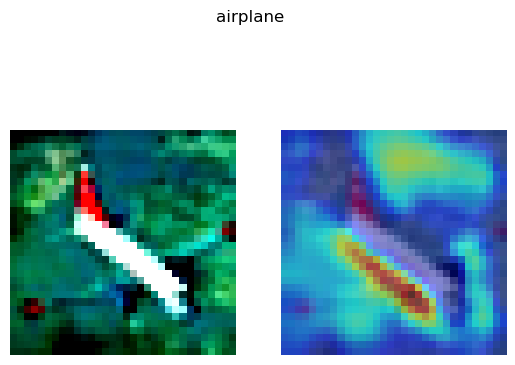

In [119]:
show_activations(model=eca_best_model, target_layers=[eca_best_model.conv1])

In [48]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Bottleneck               type        <class 'models.Bottleneck'>
CBAM                     type        <class 'models.CBAM'>
ClassifierOutputTarget   type        <class 'pytorch_grad_cam.<...>.ClassifierOutputTarget'>
GradCAM                  type        <class 'pytorch_grad_cam.grad_cam.GradCAM'>
In                       list        n=14
Out                      dict        n=1
ResNet                   type        <class 'models.ResNet'>
cifar10                  dict        n=3
cifar10_loader           dict        n=3
classes_names            dict        n=10
datetime                 type        <class 'datetime.datetime'>
deepcopy                 function    <function deepcopy at 0x7e96c13a7640>
device                   str         cuda
dill                     module      <module 'dill' from '/opt<...>ckages/dill/__init__.py'>
eca_best_model           ResNet      ResNet(\n  (conv1): Conv2<..

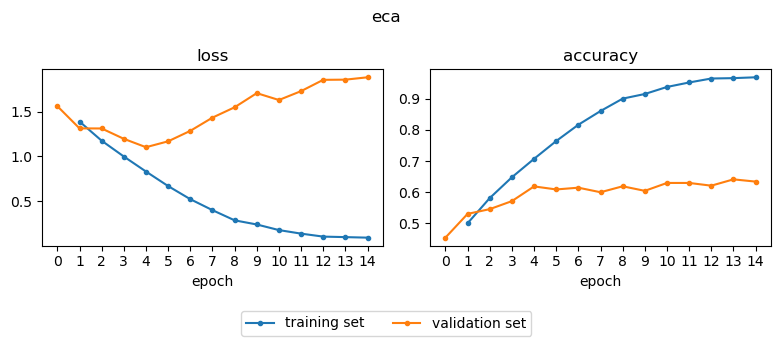

In [122]:
make_plots(eca_logging_dict, 'eca', True)